In [1]:
# cd("C:\\Users\\matsuno\\Desktop\\data_analysis\\HMMBase.jl\\src")
# include(".//HMMBase.jl")
# using .HMMBase

import Pkg
Pkg.activate("C://Users//matsuno//.julia//environments//v1.4.2//Project.toml")
Pkg.develop(Pkg.PackageSpec(url="C:\\Users\\matsuno\\Desktop\\data_analysis\\HMMBase.jl\\"))
using HMMBase

using Distributions
using Random
using PyPlot
using ArgCheck
import Base:OneTo

 Activating environment at `C:\Users\matsuno\.julia\environments\v1.4.2\Project.toml`
Path `C:\Users\matsuno\Desktop\data_analysis\HMMBase.jl\` exists and looks like the correct package. Using existing path.
  Resolving package versions...
   Updating `C:\Users\matsuno\.julia\environments\v1.4.2\Project.toml`
 [no changes]
   Updating `C:\Users\matsuno\.julia\environments\v1.4.2\Manifest.toml`
 [no changes]
┌ Info: Precompiling HMMBase [b2b3ca75-8444-5ffa-85e6-af70e2b64fe7]
└ @ Base loading.jl:1260


# old test

In [34]:
# import Pkg
# Pkg.activate("C://Users//matsuno//.julia//environments//v1.4.2//Project.toml")
# Pkg.add("HMMBase")

using Test
# using HMMBase
using Distributions
using Random

Random.seed!(2019)

hmms = [
    HMM([0.9 0.1; 0.1 0.9], [Normal(10, 1), Gamma(1, 1)]),
    HMM([0.9 0.1; 0.1 0.9], [Categorical([0.1, 0.2, 0.7]), Categorical([0.5, 0.5])]),
    HMM([0.9 0.1; 0.1 0.9], [MvNormal([0.0, 0.0], [1.0, 1.0]), MvNormal([10.0, 10.0], [1.0, 1.0])]),
]

@testset "Integration $(typeof(hmm))" for hmm in hmms, T in [0, 1, 1000]
    K = size(hmm, 1)

    # HMM API
    @test hmm !== copy(hmm)

    z, y = rand(hmm, T, seq = true)
    @test size(z, 1) == size(y, 1)
    @test size(y, 2) == size(hmm, 2)

    y = rand(hmm, z)
    @test size(z, 1) == size(y, 1)
    @test size(y, 2) == size(hmm, 2)

    LL = loglikelihoods(hmm, y)
    @test size(LL) == (T, K)

    # Forward/Backward
    α1, logtot1 = forward(hmm, y)
    β1, logtot2 = backward(hmm, y)
    γ1 = posteriors(hmm, y)
    logtot3 = loglikelihood(hmm, y)

    @test size(α1) == size(β1) == size(γ1)
    @test logtot1 ≈ logtot2 ≈ logtot3

    # Viterbi
    zv1 = viterbi(hmm, y)
    @test size(zv1) == size(z)

#     # MLE
    if T > 2
        hmm2, _ = fit_mle(hmm, y, maxiter = 1, display = :iter)
        @test size(hmm2) == size(hmm)
        @test typeof(hmm2) == typeof(hmm)

        hmm2, _ = fit_mle(hmm, y, init = nothing)
        @test size(hmm2) == size(hmm)
        @test typeof(hmm2) == typeof(hmm)

        hmm2, _ = fit_mle(hmm, y, init = :kmeans, robust = true)
        @test size(hmm2) == size(hmm)
        @test typeof(hmm2) == typeof(hmm)
    end
end

Test Summary:                       | Pass  Total
Integration HMM{Univariate,Float64} |    9      9
Test Summary:                       | Pass  Total
Integration HMM{Univariate,Float64} |    9      9
Iteration 0: logtot = -1572.9882559135876
Iteration 1: logtot = -1570.0319637275895
EM has not converged after 1 iterations, logtot = -1570.0319637275895
Test Summary:                       | Pass  Total
Integration HMM{Univariate,Float64} |   15     15
Test Summary:                       | Pass  Total
Integration HMM{Univariate,Float64} |    9      9
Test Summary:                       | Pass  Total
Integration HMM{Univariate,Float64} |    9      9
Iteration 0: logtot = -986.7151248158447
Iteration 1: logtot = -982.1393221505426
EM has not converged after 1 iterations, logtot = -982.1393221505426
Test Summary:                       | Pass  Total
Integration HMM{Univariate,Float64} |   15     15
Test Summary:                         | Pass  Total
Integration HMM{Multivariate,Float64} |    

9-element Array{Any,1}:
 Test.DefaultTestSet("Integration HMM{Univariate,Float64}", Any[], 9, false)
 Test.DefaultTestSet("Integration HMM{Univariate,Float64}", Any[], 9, false)
 Test.DefaultTestSet("Integration HMM{Univariate,Float64}", Any[], 15, false)
 Test.DefaultTestSet("Integration HMM{Univariate,Float64}", Any[], 9, false)
 Test.DefaultTestSet("Integration HMM{Univariate,Float64}", Any[], 9, false)
 Test.DefaultTestSet("Integration HMM{Univariate,Float64}", Any[], 15, false)
 Test.DefaultTestSet("Integration HMM{Multivariate,Float64}", Any[], 9, false)
 Test.DefaultTestSet("Integration HMM{Multivariate,Float64}", Any[], 9, false)
 Test.DefaultTestSet("Integration HMM{Multivariate,Float64}", Any[], 15, false)

# new test

In [37]:
using Test
using Distributions
using Random

Random.seed!(2019)

hmms = [
    HMM([0.8 0.2; 0.2 0.8], [Normal(10, 1), Gamma(1, 1)]),
    HMM([0.8 0.2; 0.2 0.8], [Categorical([0.1, 0.2, 0.7]), Categorical([0.5, 0.5])]),
    HMM([0.8 0.2; 0.2 0.8], [MvNormal([0.0, 0.0], [1.0, 1.0]), MvNormal([10.0, 10.0], [1.0, 1.0])]),
]

@testset "Integration $(typeof(hmm))" for hmm in hmms, T in [0, 1, 100], N in [0, 1, 100]
    K = size(hmm, 1)

    # HMM API
    @test hmm !== copy(hmm)

    z, y = rand(hmm, T, N, seq = true)
    @test size(z, 1) == size(y, 1)
    @test size(z, 2) == last(size(y))
    ((ndims(y) > 2) && (N >= 1)) && (@test size(y, 2) == size(hmm, 2))

    y = rand(hmm, z)
    @test size(z, 1) == size(y, 1)
    ((ndims(y) > 2) && (N >= 1)) && (@test size(y, 2) == size(hmm, 2))

    LL = loglikelihoods(hmm, y)
    @test size(LL) == (T, K, N)

    # Forward/Backward
    α1, logtot1 = forward(hmm, y)
    β1, logtot2 = backward(hmm, y)
    γ1 = posteriors(hmm, y)
    logtot3 = loglikelihood(hmm, y)

    @test size(α1) == size(β1) == size(γ1)
    @test logtot1 ≈ logtot2 ≈ logtot3
    
    # Viterbi
    zv1, _ = viterbi(hmm, y)
    @test size(zv1) == size(z)

    # MLE
    if (T > 2)&&(N > 2)
        hmm2, _ = fit_mle(hmm, y, maxiter = 1, display = :iter)
        @test size(hmm2) == size(hmm)
        @test typeof(hmm2) == typeof(hmm)

        hmm2, _ = fit_mle(hmm, y, init = nothing)
        @test size(hmm2) == size(hmm)
        @test typeof(hmm2) == typeof(hmm)

        hmm2, _ = fit_mle(hmm, y, init = :kmeans, robust = true)
        @test size(hmm2) == size(hmm)
        @test typeof(hmm2) == typeof(hmm)
    end
end

Integration HMM{Univariate,Float64}: Test Failed at In[37]:29
  Expression: size(LL) == (T, K, N)
   Evaluated: (0, 2) == (0, 2, 0)
Stacktrace:
 [1] macro expansion at .\In[37]:29 [inlined]
 [2] macro expansion at D:\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.4\Test\src\Test.jl:1186 [inlined]
 [3] top-level scope at .\In[37]:12
Integration HMM{Univariate,Float64}: Error During Test at In[37]:13
  Got exception outside of a @test
  BoundsError: attempt to access (0, 2)
    at index [3]
  Stacktrace:
   [1] indexed_iterate at .\tuple.jl:81 [inlined]
   [2] backwardlog!(::Array{Union{Nothing, Float64},2}, ::Array{Float64,2}, ::Array{Float64,1}, ::Array{Float64,2}, ::Array{Float64,2}) at C:\Users\matsuno\Desktop\data_analysis\HMMBase.jl\src\messages.jl:71
   [3] backward(::Array{Float64,1}, ::Array{Float64,2}, ::Array{Float64,2}; logl::Nothing) at C:\Users\matsuno\Desktop\data_analysis\HMMBase.jl\src\messages.jl:182
   [4] backward(::Array{Float64,1}, ::Array{Float64,2},

TestSetException: Some tests did not pass: 4 passed, 1 failed, 1 errored, 0 broken.

In [4]:
using Test
using Distributions
using Random

Random.seed!(2019)

hmms = [
    HMM([0.8 0.2; 0.2 0.8], [Normal(10, 1), Gamma(1, 1)]),
    HMM([0.8 0.2; 0.2 0.8], [Categorical([0.1, 0.2, 0.7]), Categorical([0.5, 0.5])]),
    HMM([0.8 0.2; 0.2 0.8], [MvNormal([0.0, 0.0], [1.0, 1.0]), MvNormal([10.0, 10.0], [1.0, 1.0])]),
]

@testset "Integration $(typeof(hmm))" for hmm in hmms, N in [0, 1, 100], d in [Poisson(10), Geometric(0.8)]
    K = size(hmm, 1)

    # HMM API
    @test hmm !== copy(hmm)

    z, y = rand(hmm, d, N, seq = true)
    @test size(z, 1) == size(y, 1)
    @test size(z, 2) == last(size(y))
    ((ndims(y) > 2) && (N >= 1)) && (@test size(y, 2) == size(hmm, 2))

    y = rand(hmm, z)
    @test size(z, 1) == size(y, 1)
    ((ndims(y) > 2) && (N >= 1)) && (@test size(y, 2) == size(hmm, 2))

    LL = loglikelihoods(hmm, y)
    @test size(LL) == (T, K, N)

    # Forward/Backward
    α1, logtot1 = forward(hmm, y)
    β1, logtot2 = backward(hmm, y)
    γ1 = posteriors(hmm, y)
    logtot3 = loglikelihood(hmm, y)

    @test size(α1) == size(β19) == size(γ1)
    @test logtot1 ≈ logtot2 ≈ logtot3
    
    # Viterbi
    zv1, _ = viterbi(hmm, y)
    @test size(zv1) == size(z)

    # MLE
    if (T > 2)&&(N > 2)
        hmm2, _ = fit_mle(hmm, y, maxiter = 1, display = :iter)
        @test size(hmm2) == size(hmm)
        @test typeof(hmm2) == typeof(hmm)

        hmm2, _ = fit_mle(hmm, y, init = nothing)
        @test size(hmm2) == size(hmm)
        @test typeof(hmm2) == typeof(hmm)

        hmm2, _ = fit_mle(hmm, y, init = :kmeans, robust = true)
        @test size(hmm2) == size(hmm)
        @test typeof(hmm2) == typeof(hmm)
    end
end

Integration HMM{Univariate,Float64}: Error During Test at In[4]:13
  Got exception outside of a @test
  ArgumentError: N >= 1 must hold. Got
  N => 0
  Stacktrace:
   [1] macro expansion at C:\Users\matsuno\.julia\packages\ArgCheck\TDq9c\src\checks.jl:180 [inlined]
   [2] generate_random_lengths at C:\Users\matsuno\Desktop\data_analysis\HMMBase.jl\src\hmm.jl:414 [inlined]
   [3] rand(::Random._GLOBAL_RNG, ::HMM{Univariate,Float64}, ::Poisson{Float64}, ::Int64; seq::Bool) at C:\Users\matsuno\Desktop\data_analysis\HMMBase.jl\src\hmm.jl:264
   [4] #rand#11 at C:\Users\matsuno\Desktop\data_analysis\HMMBase.jl\src\hmm.jl:314 [inlined]
   [5] macro expansion at .\In[4]:19 [inlined]
   [6] macro expansion at D:\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.4\Test\src\Test.jl:1186 [inlined]
   [7] top-level scope at .\In[4]:12
   [8] eval at .\boot.jl:331 [inlined]
   [9] softscope_include_string(::Module, ::String, ::String) at C:\Users\matsuno\.julia\packages\SoftGlobalScope\

TestSetException: Some tests did not pass: 1 passed, 0 failed, 1 errored, 0 broken.

# Univariate

In [3]:
a = [0.2, 0.8]
A = [0.9 0.1; 0.1 0.9]
B = [Normal(10, 1), Gamma(1, 1)]
hmm = HMM(a, A, B)

HMM{Univariate,Float64}([0.2, 0.8], [0.9 0.1; 0.1 0.9], Distribution{Univariate,S} where S<:ValueSupport[Normal{Float64}(μ=10.0, σ=1.0), Gamma{Float64}(α=1.0, θ=1.0)])

## fixed number of observations with fixed length

In [4]:
Random.seed!(2019)
z, y = rand(hmm, 100, 2, seq = true)
size(z)

(100, 2)

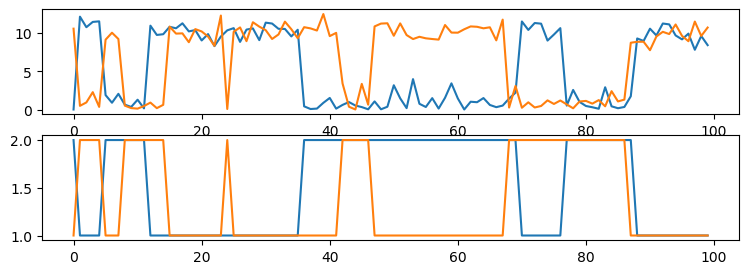

In [5]:
_, axes = subplots(nrows = 2, figsize = (9, 3))
axes[1].plot(y)
axes[2].plot(z, linestyle = "-");

In [6]:
α, logtot = forward(hmm, y)
β, logtot = backward(hmm, y)

γ = posteriors(hmm, y) # or
γ = posteriors(α, β)

size(α), size(β), size(γ)

((100, 2, 2), (100, 2, 2), (100, 2, 2))

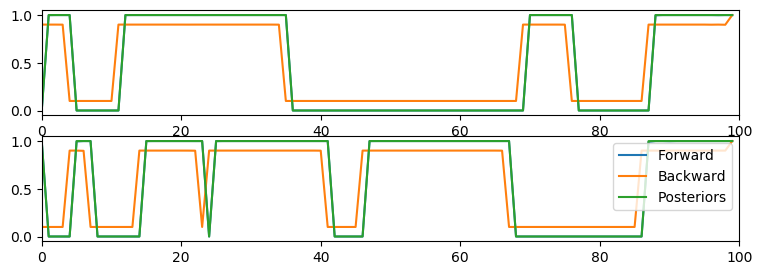

PyObject <matplotlib.legend.Legend object at 0x00000000622EFA90>

In [7]:
_, axes = subplots(nrows = 2, figsize = (9, 3))
axes[1].plot([α[:, 1, 1] β[:, 1, 1] γ[:, 1, 1]])
axes[1].set_xlim(0, size(y, 1))
axes[2].plot([α[:, 1, 2] β[:, 1, 2] γ[:, 1, 2]])
axes[2].set_xlim(0, size(y, 1))
legend(["Forward", "Backward", "Posteriors"], loc = "upper right")

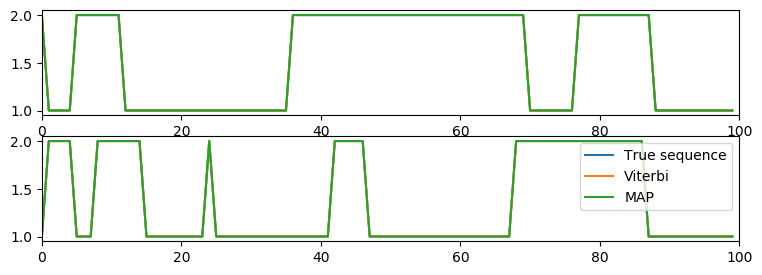

PyObject <matplotlib.legend.Legend object at 0x0000000062462CC0>

In [8]:
z_map = Matrix{Any}(nothing, size(z))
for n in 1:size(γ, 3)
    for t in 1:size(filter(!isnothing, γ[:, 1, n]), 1)
        z_map[t, n] = argmax(γ[t, :, n])
    end
end
z_viterbi = viterbi(hmm, y)

_, axes = subplots(nrows = 2, figsize = (9, 3))
axes[1].plot(z[:, 1], linestyle = "-")
axes[1].plot(z_viterbi[:, 1], linestyle = "-")
axes[1].plot(z_map[:, 1], linestyle = "-")
axes[1].set_xlim(0, size(y, 1))
axes[2].plot(z[:, 2], linestyle = "-")
axes[2].plot(z_viterbi[:, 2], linestyle = "-")
axes[2].plot(z_map[:, 2], linestyle = "-")
axes[2].set_xlim(0, size(y, 1))
legend(["True sequence", "Viterbi", "MAP"], loc = "upper right")

In [9]:
hmm, history = fit_mle(hmm, y, display = :final, init = :kmeans)

EM converged in 6 iterations, logtot = -297.2236985291553


(HMM{Univariate,Float64}([0.3946258345590855, 0.6053741654409145], [0.9210716515988014 0.07892834840119847; 0.135551152878816 0.864448847121184], Distribution{Univariate,S} where S<:ValueSupport[Normal{Float64}(μ=10.144068890207615, σ=0.9558106987565306), Gamma{Float64}(α=1.037420024276778, θ=0.9227706164984028)]), HMMBase.EMHistory(true, 6, [-361.498210273512, -300.4208193244703, -297.26002502181103, -297.2256997086753, -297.2237032633156, -297.2236985291553]))

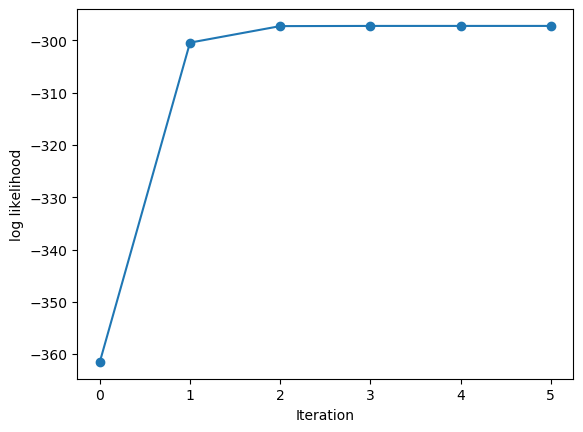

PyObject Text(24.0, 0.5, 'log likelihood')

In [10]:
plot(history.logtots, marker="o")
xlabel("Iteration")
ylabel("log likelihood")

## fixed number of observations with random length

In [11]:
a = [0.2, 0.8]
A = [0.9 0.1; 0.1 0.9]
B = [Normal(5, 1), Gamma(1, 1)]
hmm = HMM(a, A, B)

HMM{Univariate,Float64}([0.2, 0.8], [0.9 0.1; 0.1 0.9], Distribution{Univariate,S} where S<:ValueSupport[Normal{Float64}(μ=5.0, σ=1.0), Gamma{Float64}(α=1.0, θ=1.0)])

In [12]:
Random.seed!(1234)
z, y = rand(hmm, Poisson(500), 2, seq = true)

(Union{Nothing, Int64}[2 2; 2 2; … ; 2 nothing; 2 nothing], Union{Nothing, Float64}[1.3065196315496677 0.17059123896656245; 0.6932920960027175 0.15532660009365884; … ; 2.7659815690757457 nothing; 1.6904428630768742 nothing])

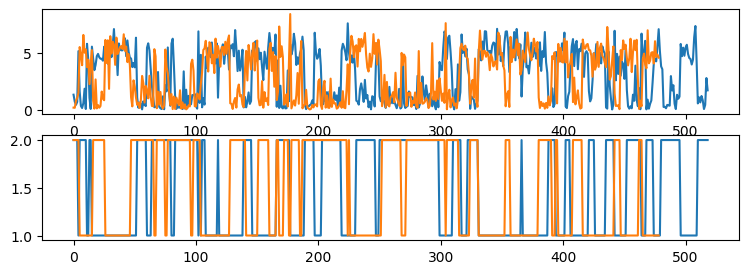

2-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000062531CF8>
 PyObject <matplotlib.lines.Line2D object at 0x0000000062552278>

In [13]:
_, axes = subplots(nrows = 2, figsize = (9, 3))
axes[1].plot(y)
axes[2].plot(z, linestyle = "-")

In [14]:
α, logtot = forward(hmm, y)
β, logtot = backward(hmm, y)

γ = posteriors(hmm, y) # or
γ = posteriors(α, β)

size(α), size(β), size(γ)

((519, 2, 2), (519, 2, 2), (519, 2, 2))

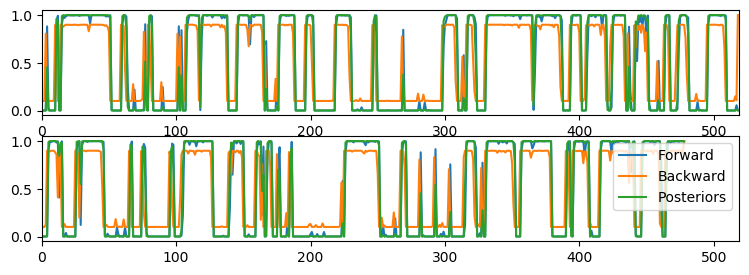

PyObject <matplotlib.legend.Legend object at 0x0000000062602E80>

In [15]:
_, axes = subplots(nrows = 2, figsize = (9, 3))
axes[1].plot([α[:, 1, 1] β[:, 1, 1] γ[:, 1, 1]])
axes[1].set_xlim(0, size(y, 1))
axes[2].plot([α[:, 1, 2] β[:, 1, 2] γ[:, 1, 2]])
axes[2].set_xlim(0, size(y, 1))
legend(["Forward", "Backward", "Posteriors"], loc = "upper right")

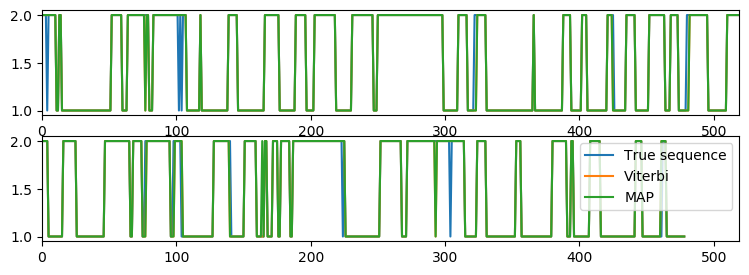

PyObject <matplotlib.legend.Legend object at 0x00000000627376D8>

In [16]:
z_map = Matrix{Any}(nothing, size(z))
for n in 1:size(γ, 3)
    for t in 1:size(filter(!isnothing, γ[:, 1, n]), 1)
        z_map[t, n] = argmax(γ[t, :, n])
    end
end
z_viterbi = viterbi(hmm, y)

_, axes = subplots(nrows = 2, figsize = (9, 3))
axes[1].plot(z[:, 1], linestyle = "-")
axes[1].plot(z_viterbi[:, 1], linestyle = "-")
axes[1].plot(z_map[:, 1], linestyle = "-")
axes[1].set_xlim(0, size(y, 1))
axes[2].plot(z[:, 2], linestyle = "-")
axes[2].plot(z_viterbi[:, 2], linestyle = "-")
axes[2].plot(z_map[:, 2], linestyle = "-")
axes[2].set_xlim(0, size(y, 1))
legend(["True sequence", "Viterbi", "MAP"], loc = "upper right")

In [17]:
hmm, history = fit_mle(hmm, y, display = :final, init = :kmeans)

EM converged in 12 iterations, logtot = -1475.9148747938784


(HMM{Univariate,Float64}([1.5918372323790184e-43, 1.0], [0.9043595220775722 0.09564047792242784; 0.09907962522926042 0.9009203747707396], Distribution{Univariate,S} where S<:ValueSupport[Normal{Float64}(μ=4.9563124105817975, σ=1.0024952374914016), Gamma{Float64}(α=1.0553712753333493, θ=0.8998413653176818)]), HMMBase.EMHistory(true, 12, [-1641.4390680916108, -1488.8141156428937, -1477.6017570390366, -1476.4327901377064, -1476.100519973598, -1475.986852486894, -1475.9448500892863, -1475.928094027247, -1475.9208348308887, -1475.9174391147628, -1475.9157507916093, -1475.9148747938784]))

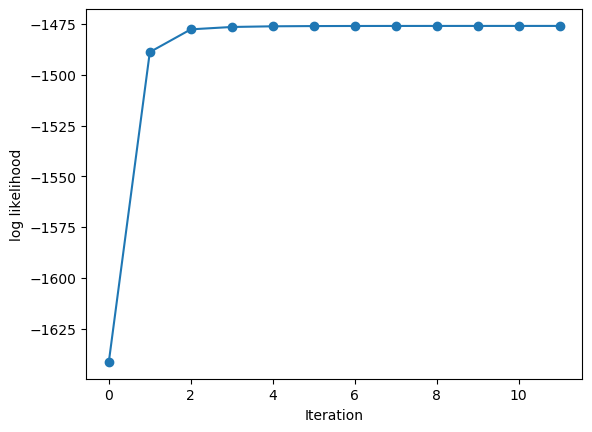

PyObject Text(24.0, 0.5, 'log likelihood')

In [18]:
plot(history.logtots, marker="o")
xlabel("Iteration")
ylabel("log likelihood")

# Multivariate

In [19]:
a = [0.6, 0.4]
A = [0.9 0.1; 0.1 0.9]
B = [MvNormal([0.0, 5.0], ones(2) * 1), MvNormal([0.0, 5.0], ones(2) * 3)]
hmm = HMM(a, A, B)
size(hmm) # (number of states, observations dimension)

(2, 2)

## fixed number of observations with fixed length

In [20]:
Random.seed!(1234)
z, y = rand(hmm, 500, 2, seq = true)
size(z)

(500, 2)

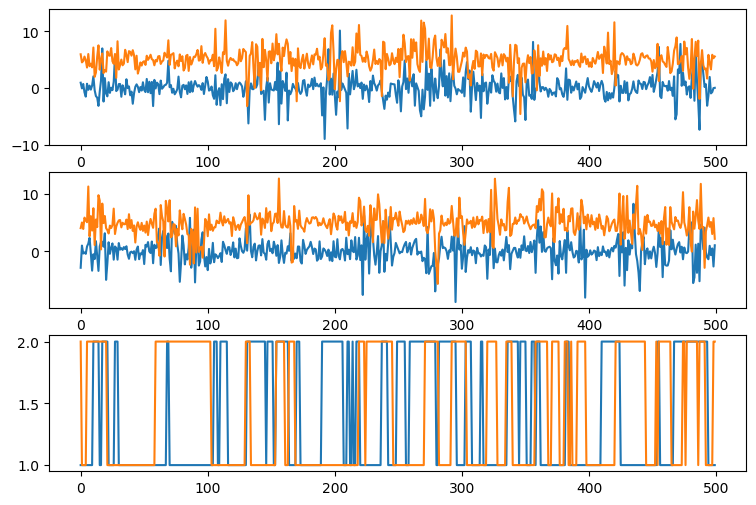

2-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000628C8B70>
 PyObject <matplotlib.lines.Line2D object at 0x00000000628D30F0>

In [21]:
_, axes = subplots(nrows = 3, figsize = (9, 6))
axes[1].plot(y[:, :, 1])
axes[2].plot(y[:, :, 2])
axes[3].plot(z, linestyle = "-")

In [22]:
α, logtot = forward(hmm, y)
β, logtot = backward(hmm, y)

γ = posteriors(hmm, y) # or
γ = posteriors(α, β)

size(α), size(β), size(γ)

((500, 2, 2), (500, 2, 2), (500, 2, 2))

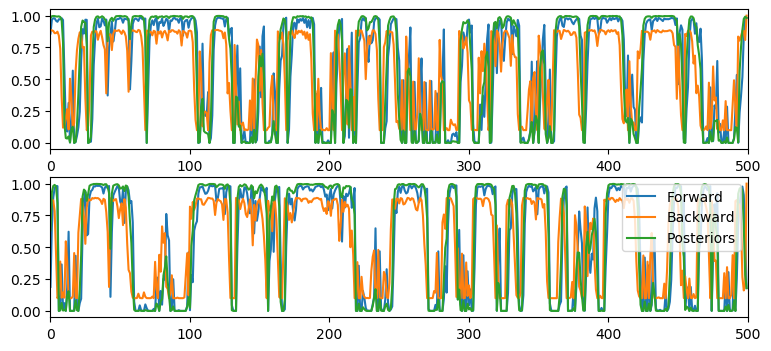

PyObject <matplotlib.legend.Legend object at 0x0000000062928358>

In [23]:
_, axes = subplots(nrows = 2, figsize = (9, 4))
axes[1].plot([α[:, 1, 1] β[:, 1, 1] γ[:, 1, 1]])
axes[1].set_xlim(0, size(y, 1))
axes[2].plot([α[:, 1, 2] β[:, 1, 2] γ[:, 1, 2]])
axes[2].set_xlim(0, size(y, 1))
legend(["Forward", "Backward", "Posteriors"], loc = "upper right")

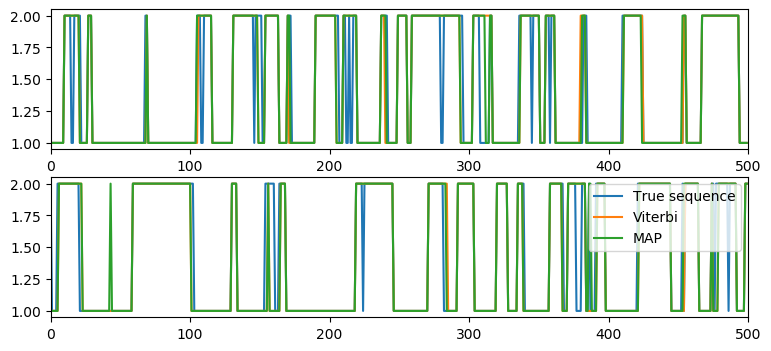

PyObject <matplotlib.legend.Legend object at 0x00000000629646A0>

In [24]:
z_map = Matrix{Any}(nothing, size(z))
for n in 1:size(γ, 3)
    for t in 1:size(filter(!isnothing, γ[:, 1, n]), 1)
        z_map[t, n] = argmax(γ[t, :, n])
    end
end
z_viterbi = viterbi(hmm, y)

_, axes = subplots(nrows = 2, figsize = (9, 4))
axes[1].plot(z[:, 1], linestyle = "-")
axes[1].plot(z_viterbi[:, 1], linestyle = "-")
axes[1].plot(z_map[:, 1], linestyle = "-")
axes[1].set_xlim(0, size(y, 1))
axes[2].plot(z[:, 2], linestyle = "-")
axes[2].plot(z_viterbi[:, 2], linestyle = "-")
axes[2].plot(z_map[:, 2], linestyle = "-")
axes[2].set_xlim(0, size(y, 1))
legend(["True sequence", "Viterbi", "MAP"], loc = "upper right")

In [25]:
hmm, history = fit_mle(hmm, y, display = :final, init = :kmeans)

CheckError: CheckError: isprobvec(hmm.a) must hold. Got
hmm.a => [NaN, NaN]

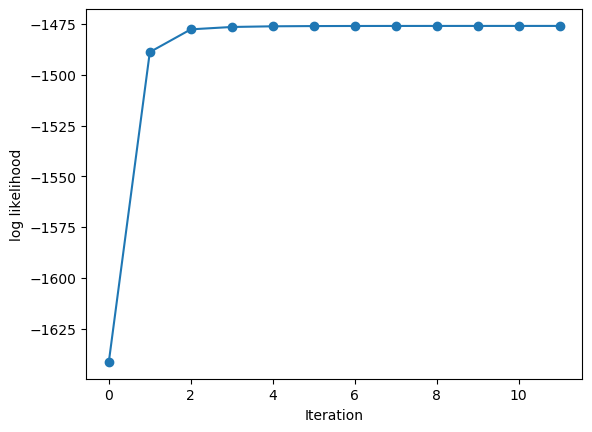

PyObject Text(24.0, 0.5, 'log likelihood')

In [26]:
plot(history.logtots, marker="o")
xlabel("Iteration")
ylabel("log likelihood")

## fixed number of observations with random length

In [27]:
Random.seed!(1234)
z, y = rand(hmm, Poisson(500), 2, seq = true)

(Union{Nothing, Int64}[1 1; 1 1; … ; 2 nothing; 2 nothing], Union{Nothing, Float64}[0.8644013132535154 7.2118774995743475; -0.27173539603462066 5.502334496388667; … ; -2.068786402644308 5.9191270361328465; -3.2773364344373537 5.365247588971641]

Union{Nothing, Float64}[2.2691421649791996 4.600520353040944; 1.1744380939121617 5.100068732616092; … ; nothing nothing; nothing nothing])

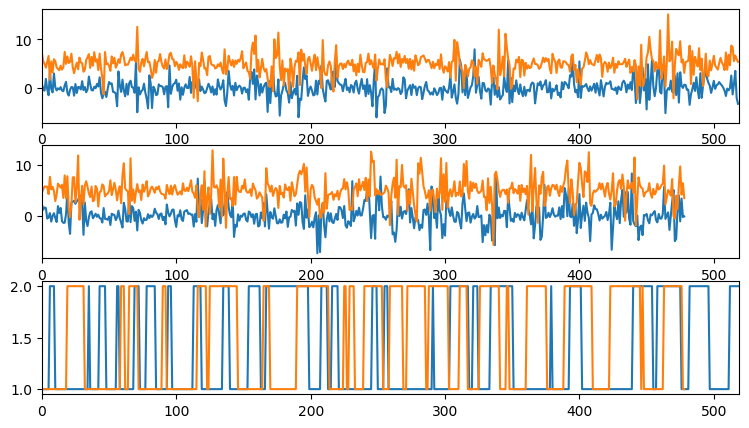

(0, 519)

In [28]:
_, axes = subplots(nrows = 3, figsize = (9, 5))
axes[1].plot(y[:, :, 1])
axes[1].set_xlim(0, size(y[:, :, 1], 1))
axes[2].plot(y[:, :, 2])
axes[2].set_xlim(0, size(y[:, :, 2], 1))
axes[3].plot(z, linestyle = "-")
axes[3].set_xlim(0, size(y[:, :, 1], 1))

In [29]:
# not implemented yet...

α, logtot = forward(hmm, y)
β, logtot = backward(hmm, y)

γ = posteriors(hmm, y) # or
γ = posteriors(α, β)

size(α), size(β), size(γ)

((519, 2, 2), (519, 2, 2), (519, 2, 2))

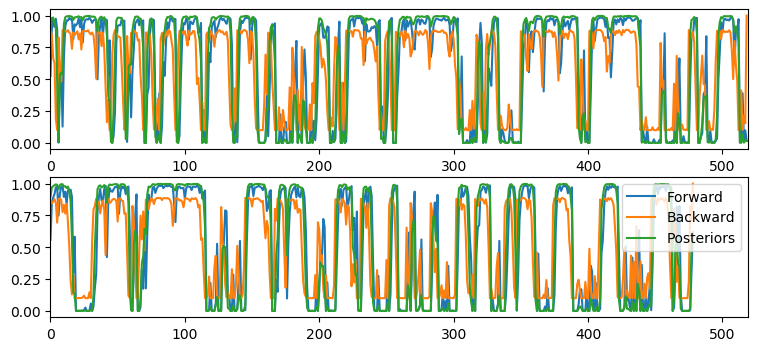

PyObject <matplotlib.legend.Legend object at 0x0000000062FB57F0>

In [30]:
_, axes = subplots(nrows = 2, figsize = (9, 4))
axes[1].plot([α[:, 1, 1] β[:, 1, 1] γ[:, 1, 1]])
axes[1].set_xlim(0, size(y, 1))
axes[2].plot([α[:, 1, 2] β[:, 1, 2] γ[:, 1, 2]])
axes[2].set_xlim(0, size(y, 1))
legend(["Forward", "Backward", "Posteriors"], loc = "upper right")

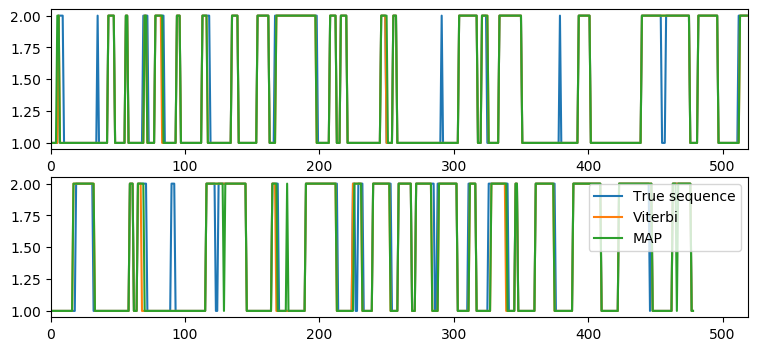

PyObject <matplotlib.legend.Legend object at 0x00000000631D9588>

In [31]:
z_map = Matrix{Any}(nothing, size(z))
for n in 1:size(γ, 3)
    for t in 1:size(filter(!isnothing, γ[:, 1, n]), 1)
        z_map[t, n] = argmax(γ[t, :, n])
    end
end
z_viterbi = viterbi(hmm, y)

_, axes = subplots(nrows = 2, figsize = (9, 4))
axes[1].plot(z[:, 1], linestyle = "-")
axes[1].plot(z_viterbi[:, 1], linestyle = "-")
axes[1].plot(z_map[:, 1], linestyle = "-")
axes[1].set_xlim(0, size(y, 1))
axes[2].plot(z[:, 2], linestyle = "-")
axes[2].plot(z_viterbi[:, 2], linestyle = "-")
axes[2].plot(z_map[:, 2], linestyle = "-")
axes[2].set_xlim(0, size(y, 1))
legend(["True sequence", "Viterbi", "MAP"], loc = "upper right")

In [32]:
hmm, history = fit_mle(hmm, y, display = :final, init = :kmeans)

EM converged in 18 iterations, logtot = -4009.3772370519778


(HMM{Multivariate,Float64}([7.213539559022319e-11, 0.9999999999278646], [0.9042096639831442 0.09579033601685576; 0.09131971966736928 0.9086802803326307], Distribution{Multivariate,S} where S<:ValueSupport[DiagNormal(
dim: 2
μ: [0.28813622674139316, 4.750221085794054]
Σ: [8.461353442981023 0.0; 0.0 10.698649143839269]
)
, DiagNormal(
dim: 2
μ: [-0.039859874478885934, 5.014783025707346]
Σ: [0.9706321506033843 0.0; 0.0 1.1179588489249763]
)
]), HMMBase.EMHistory(true, 18, [-4317.258485879317, -4234.047262604144, -4130.311310609577, -4057.1617011239105, -4024.953293304756, -4013.42199856328, -4009.972022596193, -4009.2179839499504, -4009.1680978332442, -4009.2383204255098, -4009.2990969413618, -4009.336178669754, -4009.3564463718176, -4009.3670269116865, -4009.372434323851, -4009.3751695853452, -4009.376546107703, -4009.3772370519778]))

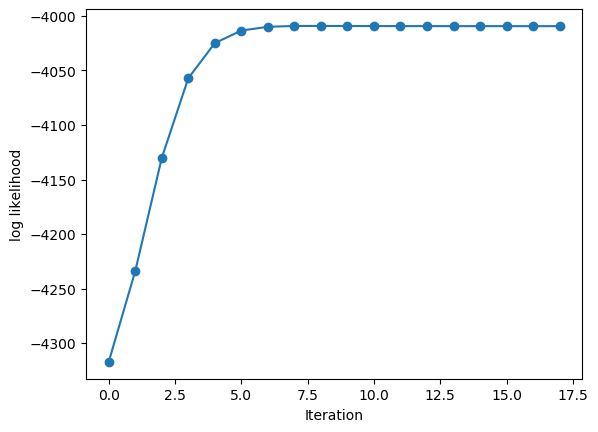

PyObject Text(24.0, 0.5, 'log likelihood')

In [33]:
plot(history.logtots, marker="o")
xlabel("Iteration")
ylabel("log likelihood")